# Imports

In [1]:
# install additional packages if running on Emscripten
import platform

notebook_platform = platform.uname()
if notebook_platform.system == "Emscripten":
    import piplite

    await piplite.install(["openpyxl", "seaborn", "lmfit"])

In [2]:
from enum import Enum
import pathlib
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import lmfit
import matplotlib.pyplot as plt

sns.set_style("ticks", {"axes.grid": True})

# Detector data

In [3]:
this_file = pathlib.Path().absolute()
data_dir = this_file.parent / "data"
data_dir

WindowsPath('c:/Users/Legion/workspace/tld_let_calibration/data')

In [4]:
radiation = Enum("rad_type", "proton Co60")
detector = Enum("detector", "mcp mts")

In [5]:
df_eff = pd.read_csv(data_dir / "interim" / "proton_eff.csv")
df_eff

,detector,energy_MeV,pmma_wheel_steps,det_id,eff
0,mts,4.92,6895,61,0.985627
1,mts,4.92,6895,62,0.984895
2,mts,4.92,6895,63,0.980375
3,mts,4.92,6895,64,0.993604
4,mts,4.92,6895,65,0.976298
...,...,...,...,...,...
126,mcp,55.00,0,2,0.838465
127,mcp,55.00,0,3,0.843554
128,mcp,55.00,0,4,0.842029
129,mcp,55.00,0,5,0.845122


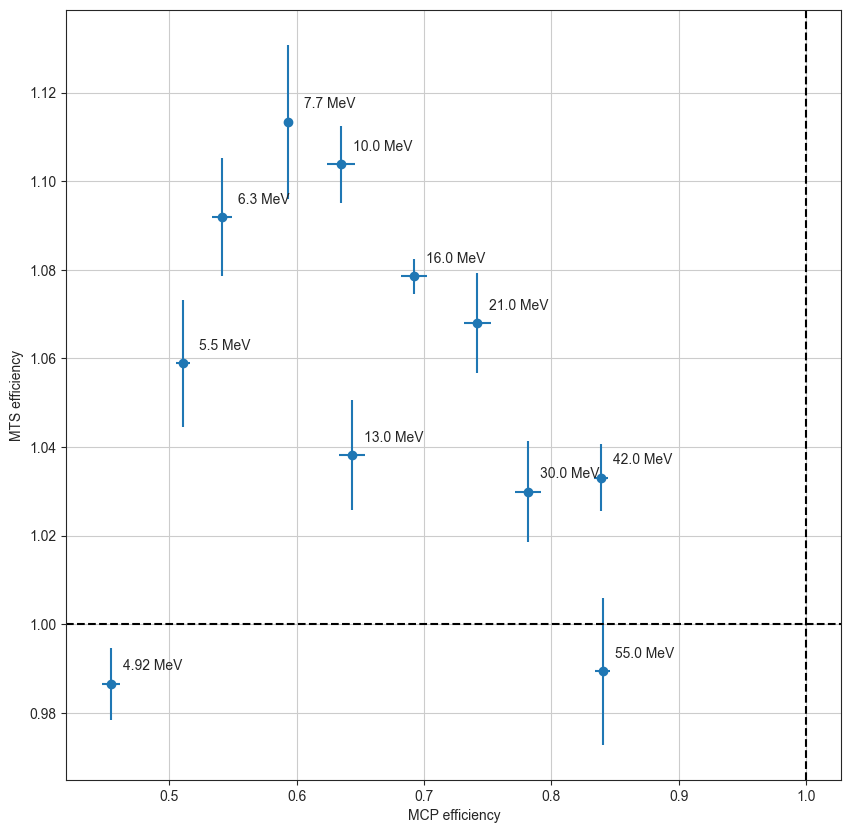

In [6]:
df_scatter = df_eff.groupby(["energy_MeV", "detector"]).eff.mean()
df_scatter_err = df_eff.groupby(["energy_MeV", "detector"]).eff.std()

fig, ax = plt.subplots(figsize=(10, 10))
ax.errorbar(
    x=df_scatter[:, detector.mcp.name],
    y=df_scatter[:, detector.mts.name],
    xerr=df_scatter_err[:, detector.mcp.name],
    yerr=df_scatter_err[:, detector.mts.name],
    fmt="o",
)
ax.set_xlabel("MCP efficiency")
ax.set_ylabel("MTS efficiency")

# Add text labels over each point
for x, y, label in zip(
    df_scatter[:, detector.mcp.name], df_scatter[:, detector.mts.name], df_scatter_err.loc[:, detector.mcp.name].index
):
    ax.annotate(f"{label} MeV", (x, y), textcoords="offset points", xytext=(30, 10), ha="center")

ax.axvline(1, color="black", linestyle="--")
ax.axhline(1, color="black", linestyle="--")

# ax.set_xlim(0.4, 1.2)
# ax.set_ylim(0.4, 1.2)
# ax.set_ylim(0, None)

In [7]:
for name, df in df_eff.groupby(["detector", "energy_MeV"]):
    eff_perc_err = 100 * df.eff.std() / df.eff.mean()
    print(f"{name[0]}, {name[1]} MeV: eff = {df.eff.mean():.2f} +- {eff_perc_err:.2f}%")

mcp, 4.92 MeV: eff = 0.45 +- 1.63%
mcp, 5.5 MeV: eff = 0.51 +- 1.08%
mcp, 6.3 MeV: eff = 0.54 +- 1.44%
mcp, 7.7 MeV: eff = 0.59 +- 0.49%
mcp, 10.0 MeV: eff = 0.64 +- 1.72%
mcp, 13.0 MeV: eff = 0.64 +- 1.57%
mcp, 16.0 MeV: eff = 0.69 +- 1.52%
mcp, 21.0 MeV: eff = 0.74 +- 1.44%
mcp, 30.0 MeV: eff = 0.78 +- 1.29%
mcp, 42.0 MeV: eff = 0.84 +- 0.67%
mcp, 55.0 MeV: eff = 0.84 +- 0.72%
mts, 4.92 MeV: eff = 0.99 +- 0.83%
mts, 5.5 MeV: eff = 1.06 +- 1.35%
mts, 6.3 MeV: eff = 1.09 +- 1.22%
mts, 7.7 MeV: eff = 1.11 +- 1.56%
mts, 10.0 MeV: eff = 1.10 +- 0.79%
mts, 13.0 MeV: eff = 1.04 +- 1.19%
mts, 16.0 MeV: eff = 1.08 +- 0.36%
mts, 21.0 MeV: eff = 1.07 +- 1.06%
mts, 30.0 MeV: eff = 1.03 +- 1.11%
mts, 42.0 MeV: eff = 1.03 +- 0.73%
mts, 55.0 MeV: eff = 0.99 +- 1.67%


Text(0, 0.5, 'Efficiency')

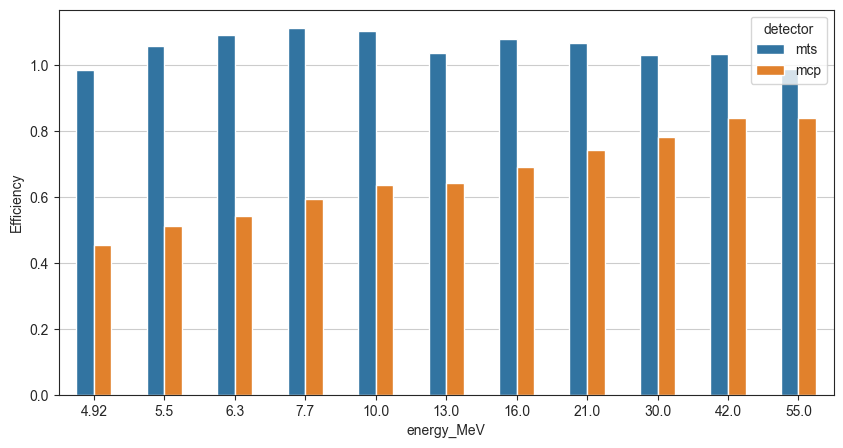

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(df_eff, x="energy_MeV", y="eff", hue="detector", errorbar=None, width=0.5, ax=ax)
ax.set_ylabel("Efficiency")

Text(0, 0.5, 'Relative error [%]')

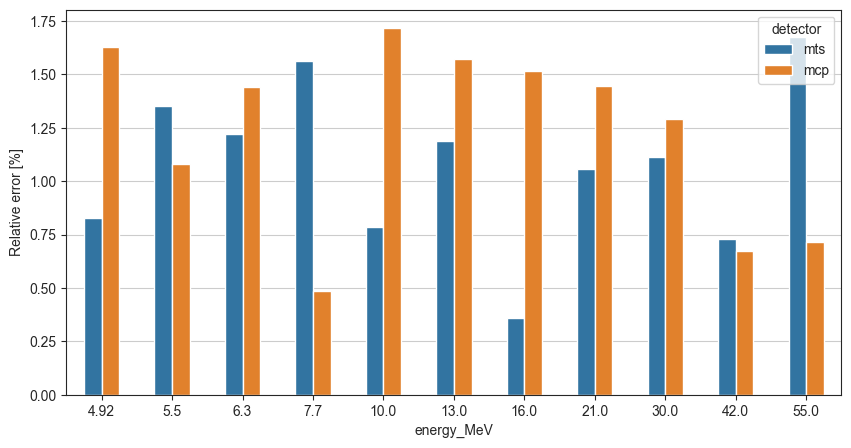

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(
    df_eff,
    x="energy_MeV",
    y="eff",
    hue="detector",
    estimator=lambda x: 100 * x.std() / x.mean(),
    errorbar=None,
    width=0.5,
    ax=ax,
)
ax.set_ylabel("Relative error [%]")

c:\Users\Legion\workspace\tld_let_calibration\.venv\Lib\site-packages\seaborn\relational.py:721: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)


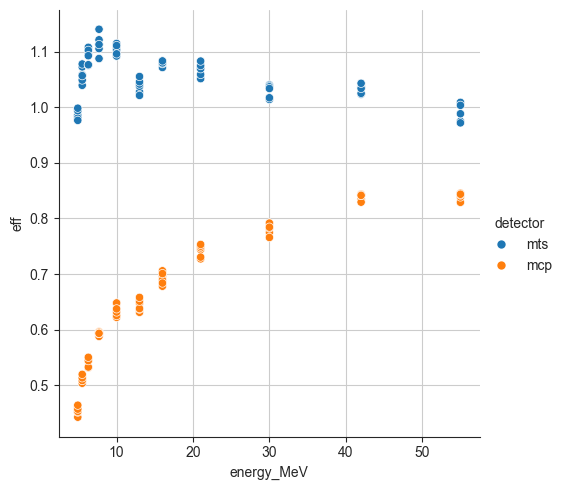

In [10]:
sns.relplot(
    df_eff,
    x="energy_MeV",
    y="eff",
    hue="detector",
    kind="scatter",
    ax=ax,
)

# Fitting

In [11]:
from lmfit.models import LinearModel, ConstantModel, ExponentialModel

model = ConstantModel() + ExponentialModel()

In [12]:
x = df_eff.loc[df_eff.detector == detector.mcp.name, "energy_MeV"].values
y = df_eff.loc[df_eff.detector == detector.mcp.name, "eff"].values

In [13]:
params = model.make_params()
params

name,value,initial value,min,max,vary
c,0.00000000,None,-inf,inf,True
amplitude,1.00000000,None,-inf,inf,True
decay,1.00000000,None,-inf,inf,True


In [14]:
result = model.fit(y, params, x=x)
result

<Axes: title={'center': '(Model(constant) + Model(exponential))'}, xlabel='x', ylabel='y'>

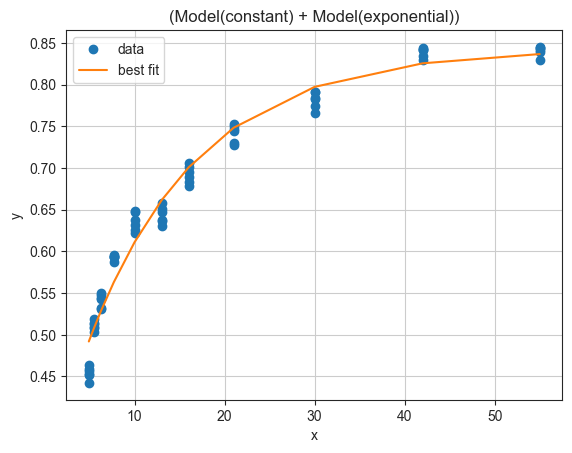

In [15]:
result.plot_fit()

<Axes: title={'center': '(Model(constant) + Model(exponential))'}, ylabel='residuals'>

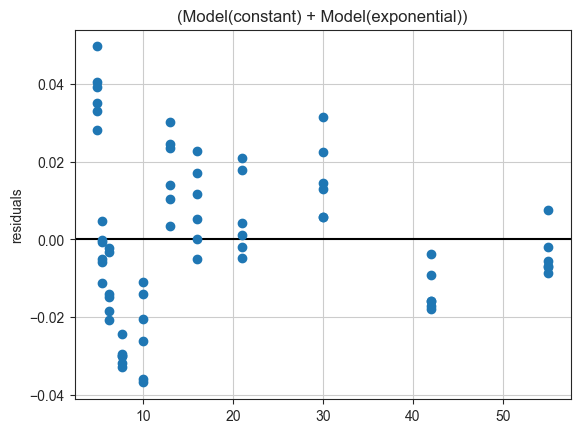

In [16]:
result.plot_residuals()

In [17]:
def predict_eff(x, params=result.params):
    return model.eval(params, x=x)

In [18]:
predict_eff(x)

array([0.49198101, 0.49198101, 0.49198101, 0.49198101, 0.49198101,
       0.49198101, 0.50819694, 0.50819694, 0.50819694, 0.50819694,
       0.50819694, 0.50819694, 0.52933975, 0.52933975, 0.52933975,
       0.52933975, 0.52933975, 0.52933975, 0.56317255, 0.56317255,
       0.56317255, 0.56317255, 0.56317255, 0.56317255, 0.61100376,
       0.61100376, 0.61100376, 0.61100376, 0.61100376, 0.61100376,
       0.661301  , 0.661301  , 0.661301  , 0.661301  , 0.661301  ,
       0.661301  , 0.70066686, 0.70066686, 0.70066686, 0.70066686,
       0.70066686, 0.70066686, 0.74820012, 0.74820012, 0.74820012,
       0.74820012, 0.74820012, 0.74820012, 0.79725344, 0.79725344,
       0.79725344, 0.79725344, 0.79725344, 0.79725344, 0.82547851,
       0.82547851, 0.82547851, 0.82547851, 0.82547851, 0.82547851,
       0.83656846, 0.83656846, 0.83656846, 0.83656846, 0.83656846,
       0.83656846])

In [19]:
x_mean = df_eff[df_eff.detector == detector.mcp.name].groupby("energy_MeV").energy_MeV.mean().values
y_mean = df_eff[df_eff.detector == detector.mcp.name].groupby("energy_MeV").eff.mean().values
x_mean, y_mean

(array([ 4.92,  5.5 ,  6.3 ,  7.7 , 10.  , 13.  , 16.  , 21.  , 30.  ,
        42.  , 55.  ]),
 array([0.45429533, 0.51113334, 0.54155448, 0.59292544, 0.63510341,
        0.64356339, 0.69204975, 0.74191294, 0.78167339, 0.83871034,
        0.84024058]))

Text(0, 0.5, 'Relative error [%]')

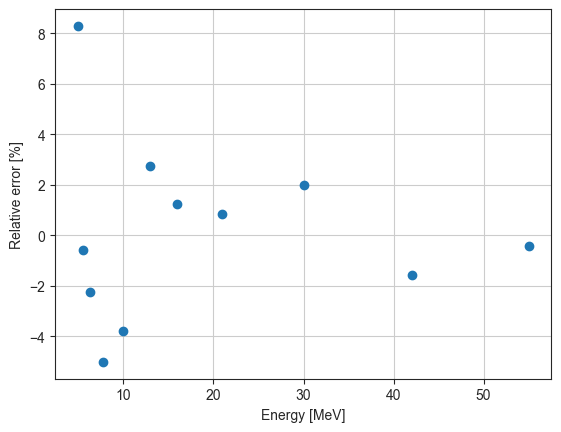

In [20]:
plt.plot(x_mean, 100 * predict_eff(x_mean) / y_mean - 100, linestyle="none", marker="o")
plt.xlabel("Energy [MeV]")
plt.ylabel("Relative error [%]")

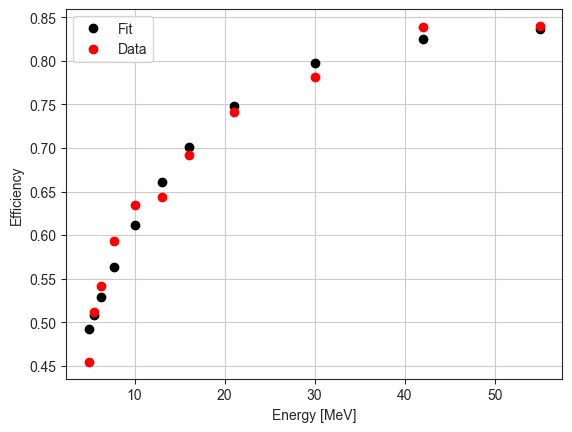

In [21]:
plt.plot(x_mean, predict_eff(x_mean), linestyle="none", marker="o", color="black")
plt.plot(x_mean, y_mean, linestyle="none", marker="o", color="red")
plt.xlabel("Energy [MeV]")
plt.ylabel("Efficiency")
plt.legend(["Fit", "Data"])

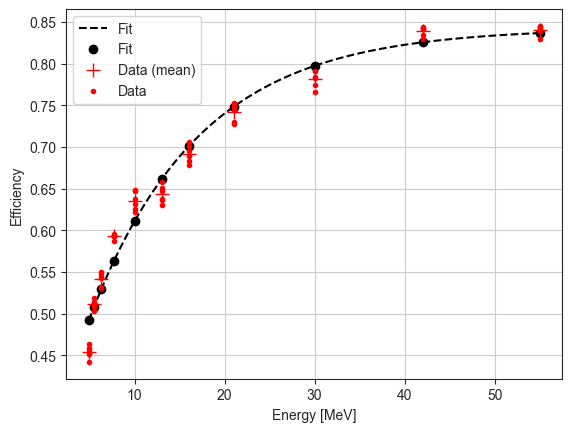

In [22]:
x_vector = np.linspace(x_mean.min(), x_mean.max(), 100)
y_vector = predict_eff(x_vector)
plt.plot(x_vector, y_vector, linestyle="--", color="black", label="Fit")
plt.plot(x_mean, predict_eff(x_mean), linestyle="none", marker="o", color="black", label="Fit")
plt.plot(x_mean, y_mean, linestyle="none", marker="+", markersize=10, color="red", label="Data (mean)")
plt.plot(x, y, linestyle="none", marker=".", color="red", label="Data")
plt.xlabel("Energy [MeV]")
plt.ylabel("Efficiency")
plt.legend()

In [23]:
def predict_ekinergy_single(eff, params=result.params):
    def func(ekin, params):
        return model.eval(params, x=ekin) - eff

    result = scipy.optimize.root(func, x0=1, args=(params,))
    return result.x[0]

In [24]:
def predict_ekinergy(eff, params=result.params):
    return np.array([predict_ekinergy_single(e, params) for e in eff])

In [25]:
predict_ekinergy(y_mean)

array([ 3.66960288,  5.60803022,  6.78718159,  9.07918186, 11.34623759,
       11.85626447, 15.27758835, 20.20927014, 26.37265697, 60.5669998 ,
       67.054276  ])

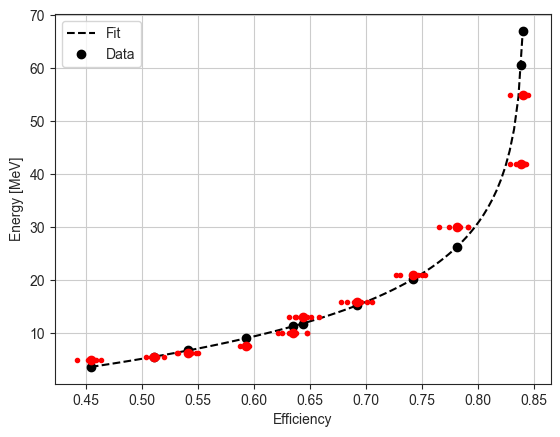

In [26]:
y_vector = np.linspace(y_mean.min(), y_mean.max(), 100)
x_vector = predict_ekinergy(y_vector)
plt.plot(y_vector, x_vector, linestyle="--", color="black", label="Fit")
plt.plot(y_mean, predict_ekinergy(y_mean), linestyle="none", marker="o", color="black")
plt.plot(y_mean, x_mean, linestyle="none", marker="o", color="red")
plt.plot(y, x, linestyle="none", marker=".", color="red")
plt.xlabel("Efficiency")
plt.ylabel("Energy [MeV]")
plt.legend(["Fit", "Data"])